In [1]:
#Código para el TFM de Víctor Gabaldón Moreno (vicgabal@ucm.es) sobre Análisis de la contaminación lumínica en Madrid usando imagenes desde el espacio
#Tipos de fuentes, clasificación de fuentes, conteos, graficos, etc.

from astropy.io import ascii
import photutils
import astropy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as f
import astropy.io.fits as fits
from math import pi
import pandas
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import lmfit as lm
from photutils import detect_threshold
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import os,sys,glob
import matplotlib as mpl
from matplotlib.pyplot import figure, show, rc, grid, savefig
from matplotlib.ticker import MultipleLocator
import numpy as np
from pylab import *
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats
from photutils import datasets
from photutils import DAOStarFinder
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
import pandas as pd
import matplotlib.path as mpath

dpi=250
plt.rcParams['figure.dpi']= dpi

#%matplotlib qt

Nº puntos totales=349
% CajaLPS0.0
% Caja HPS=0.28653295128939826
% Caja HPS_LEDPCamber_wl_incand_otherLEDS=2.292263610315186
% cajaNeutralWhiteLamps_LED3000K_fluorescents=10.601719197707736
% cajaHighHg_GreenishLEDs=6.303724928366762
% CajaLEDs4000or5000K_veryblue_MHlamps=74.21203438395415
% CajaEWL_ECL_orProblemswithND=2.292263610315186
% Puntos fuera de la zona=4.011461318051573


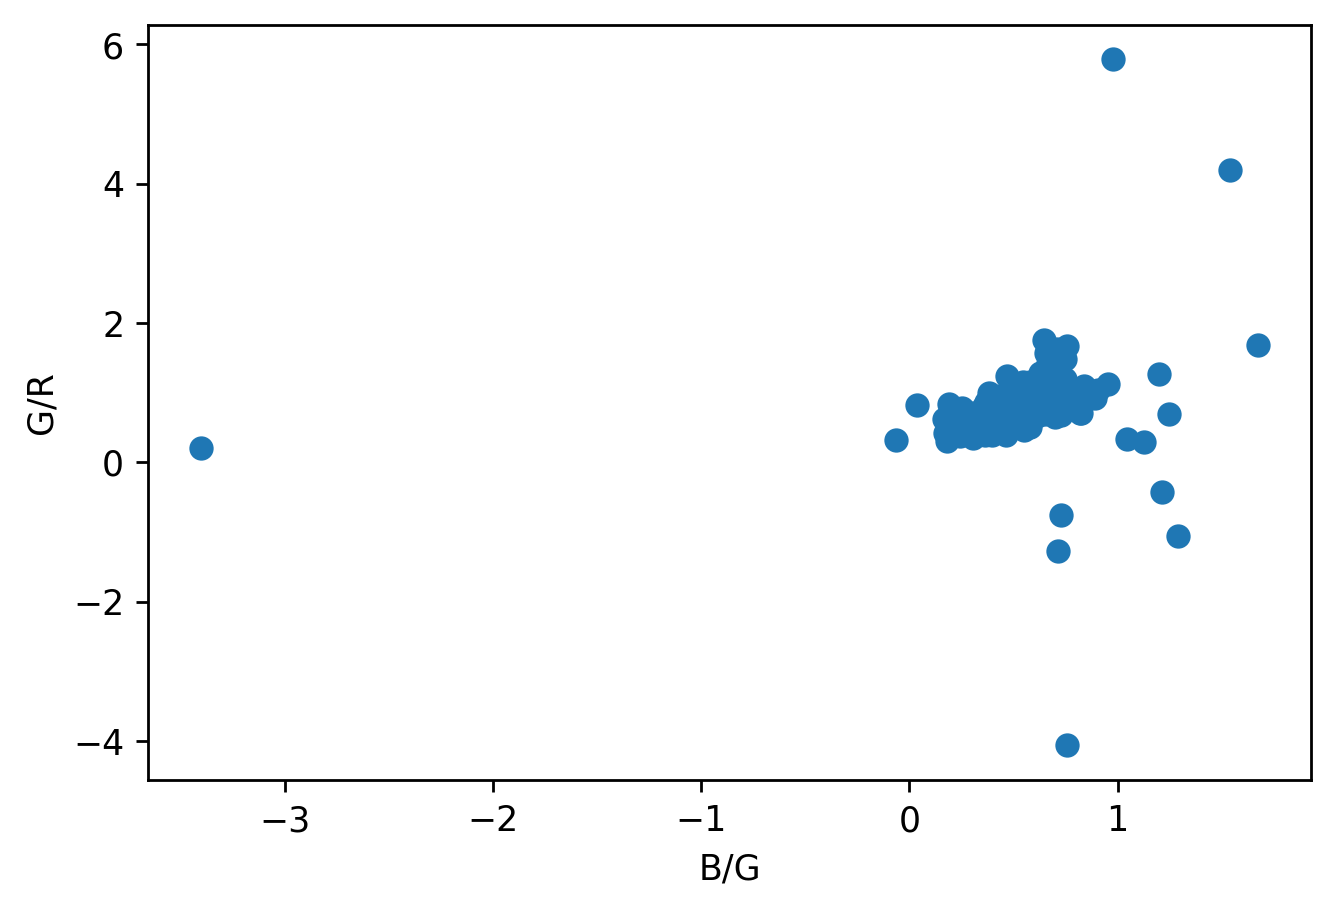

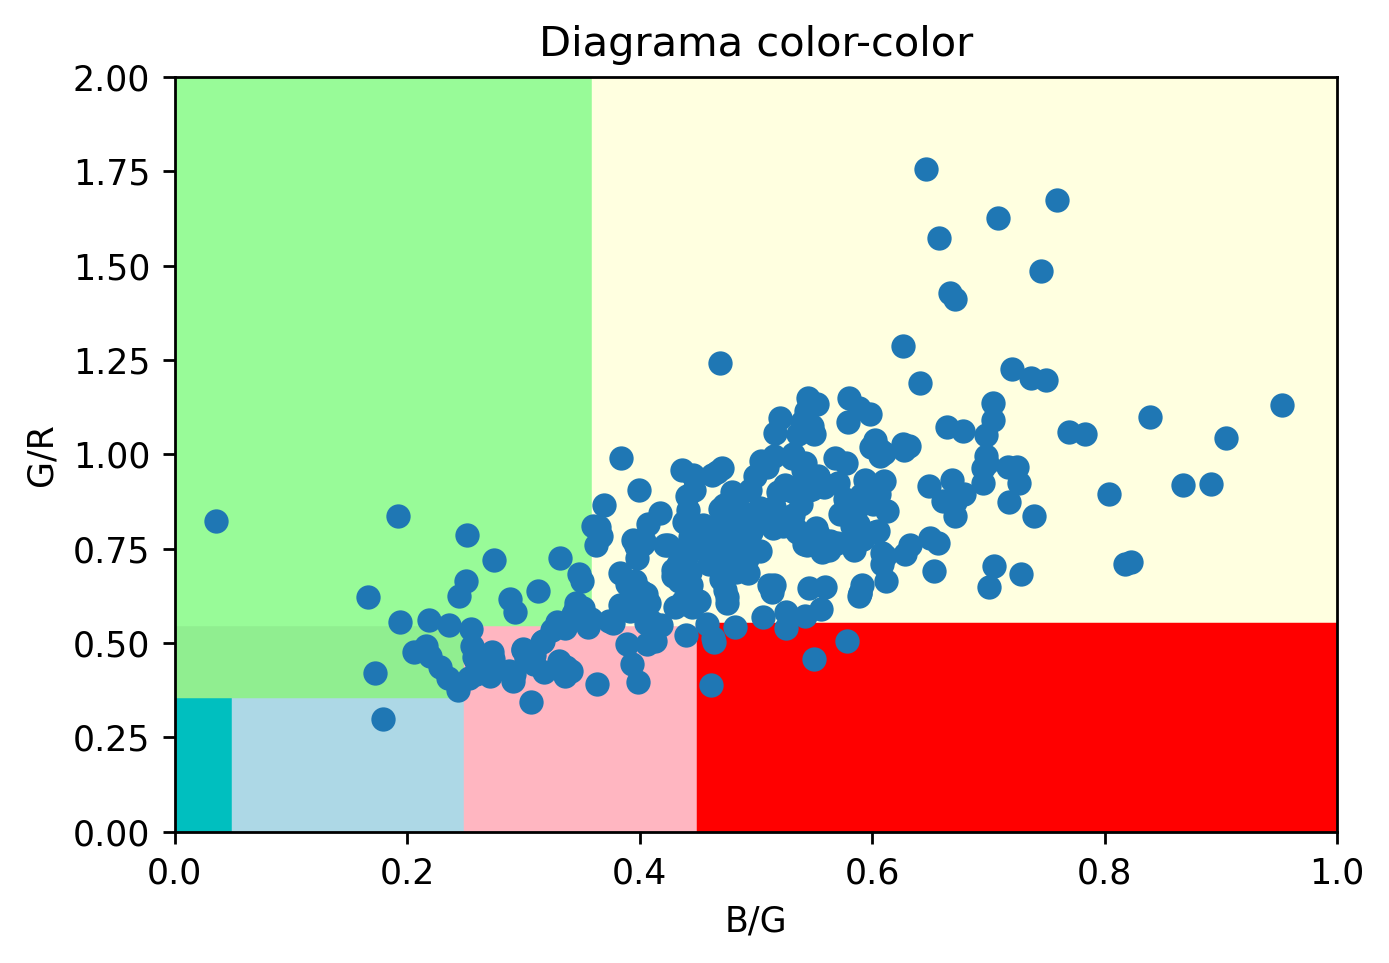

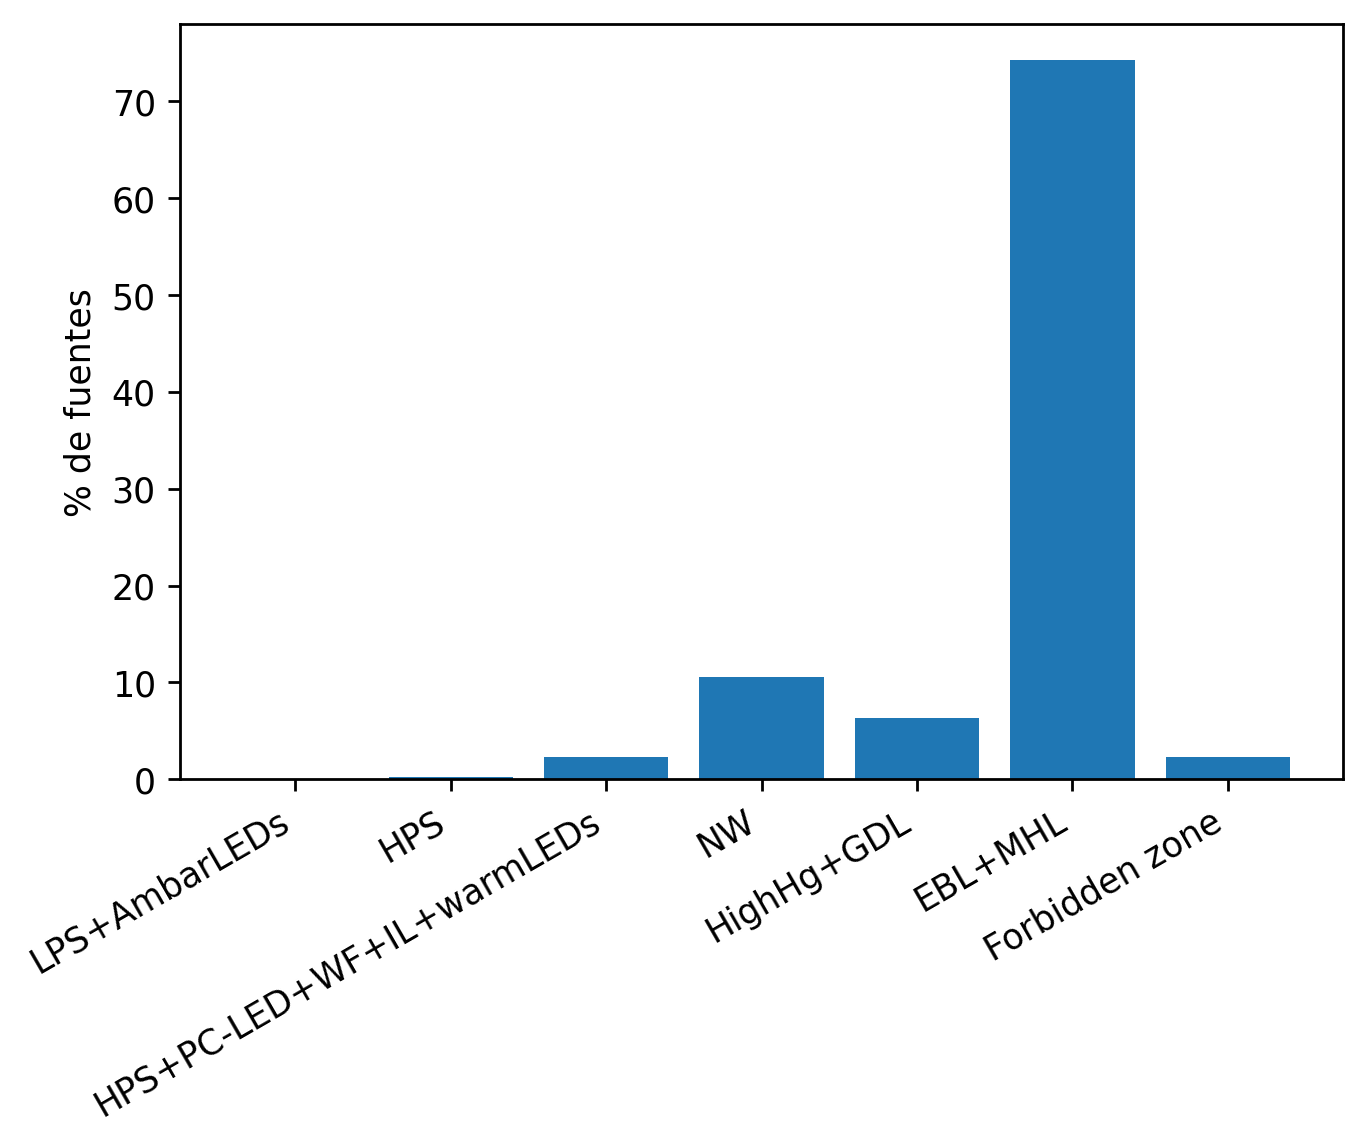

In [2]:
#ANÁLISIS DEL COLOR DE LA IMAGEN MÁS RECIENTE DE MADRID EN SUS 4 BANDAS Y TODAS SUS FUENTES POR SEPARADO

directory_load = '.\Ficheros_fits_test\\'
files = [i for i in os.listdir(directory_load) if i.startswith("Corr_iss062e102209")]
tablas=[]
canales=[]

for index, file in enumerate(files):
    if str(file).endswith('.cal2N.Ao2_rect.fits'):
        canal = str(file)[:-(len('.cal2N.Ao2_rect.fits'))]
        canales.append(canal)
    img = fits.open(directory_load+file)
    tabla = pd.read_csv('.\Fuentes_puntuales_referencia_verde\\'+str(file)+'.csv',sep=';')
#     sources_byflux=tabla.sort_values(by='aperture_sum', ascending=False, ignore_index=True) #AQUÍ SE ORDENAN POR FLUJO, BORRAR SI NO SE USA
    tablas.append(tabla) #CAMBIAR POR tabla EN VEZ DE sources_by_flux
    
Corr_iss062e102209B4F=tablas[0]
Corr_iss062e102209G2F=tablas[1]
Corr_iss062e102209G3F=tablas[2]
Corr_iss062e102209R1F=tablas[3]

G_R=Corr_iss062e102209G2F.loc[:,'aperture_sum']/Corr_iss062e102209R1F.loc[:,'aperture_sum']
B_G=Corr_iss062e102209B4F.loc[:,'aperture_sum']/Corr_iss062e102209G2F.loc[:,'aperture_sum']

plt.plot(B_G,G_R,'o')
plt.ylabel('G/R')
plt.xlabel('B/G')

#CONTADOR. Cuenta los puntos en cada región


x=B_G
y=G_R
N_tot=len(G_R) #número total de puntos.
print("Nº puntos totales="+str(N_tot))

#se dibuja el diagrama de color-color
plt.figure()
plt.plot(x,y,'o')
plt.title('Diagrama color-color') 
plt.ylabel('G/R') #titulo del eje y
plt.xlabel('B/G') #titulo del eje x

#caja 1:

points = np.column_stack([x, y])
cajaLPS = np.array([[0,0.05,0.05,0,0], [0,0,0.36,0.36,0]]).T #definición de la caja por puntos low pressure sodium/ pure amber led
path = mpath.Path(cajaLPS)
points_inside = points[path.contains_points(points)]
plt.fill([0,0.05,0.05,0,0], [0,0,0.36,0.36,0], color='c', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape #contador de puntos dentro de la región
a_por100=100*a/N_tot #cálculo del porcentaje de puntos respecto al numero total de estrellas
LPS=a_por100
print("% CajaLPS" +str(LPS))

#caja 2

points = np.column_stack([x, y])
cajaHPS = np.array([[0.05,0.25,0.25,0.05,0.05], [0,0,0.36,0.36,0]]).T #definición de la caja por puntos high pressure sodium
path = mpath.Path(cajaHPS)
points_inside = points[path.contains_points(points)]
plt.fill([0.05,0.25,0.25,0.05,0.05], [0,0,0.36,0.36,0], color='lightblue', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
HPS=a_por100
print("% Caja HPS=" +str(HPS))

#caja 3

points = np.column_stack([x, y])
cajaHPS_LEDPCamber_wl_incand_otherLEDS=np.array([[0,0.25,0.25,0,0], [0.36,0.36,0.55,0.55,0.36]]).T   #combination of HPS, LED phosphor converted (PC) amber, some warm light fluorescents, incandescent lamps and other warm LEDs
path = mpath.Path(cajaHPS_LEDPCamber_wl_incand_otherLEDS)
points_inside = points[path.contains_points(points)]
plt.fill([0,0.25,0.25,0,0], [0.36,0.36,0.55,0.55,0.36], color='lightgreen', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
HPS_LEDPCamber_wl_incand_otherLEDS=a_por100
print("% Caja HPS_LEDPCamber_wl_incand_otherLEDS=" +str(HPS_LEDPCamber_wl_incand_otherLEDS))

#caja 4

points = np.column_stack([x, y])
cajaNeutralWhiteLamps_LED3000K_fluorescents=np.array([[0.25,0.45,0.45,0.25,0.25], [0,0,0.55,0.55,0]]).T  #where neutral white lamps like LED 3000k and many fluorescents lie
path = mpath.Path(cajaNeutralWhiteLamps_LED3000K_fluorescents)
points_inside = points[path.contains_points(points)]
plt.fill([0.25,0.45,0.45,0.25,0.25], [0,0,0.55,0.55,0], color='lightpink', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
NeutralWhiteLamps_LED3000K_fluorescents=a_por100
print("% cajaNeutralWhiteLamps_LED3000K_fluorescents=" +str(NeutralWhiteLamps_LED3000K_fluorescents))

#caja 5

points = np.column_stack([x, y])
cajaHighHg_GreenishLEDs=np.array([[0,0.36,0.36,0,0], [0.55,0.55,2,2,0.55]]).T    #we find lamps with high mercury content, and some LEDs many of which have a greenish colour as a result of degradation from their original specification
path = mpath.Path(cajaHighHg_GreenishLEDs)
points_inside = points[path.contains_points(points)]
plt.fill([0,0.36,0.36,0,0], [0.55,0.55,2,2,0.55], color='palegreen', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
HighHg_GreenishLEDs=a_por100
print("% cajaHighHg_GreenishLEDs=" +str(HighHg_GreenishLEDs))


#caja 6:

points = np.column_stack([x, y])
cajaLEDs4000or5000K_veryblue_MHlamps=np.array([[0.36,1,1,0.36,0.36], [0.55,0.55,2,2,0.55]]).T   #has the more bluish lamps like LEDs of 4000k and 5000k, and metal halide lamps
path = mpath.Path(cajaLEDs4000or5000K_veryblue_MHlamps)
points_inside = points[path.contains_points(points)]
plt.fill([0.36,1,1,0.36,0.36], [0.55,0.55,2,2,0.55], color='lightyellow', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
LEDs4000or5000K_veryblue_MHlamps=a_por100
print("% CajaLEDs4000or5000K_veryblue_MHlamps=" +str(LEDs4000or5000K_veryblue_MHlamps))


#caja 7:

points = np.column_stack([x, y])
cajaEWL_ECL_orProblemswithND= np.array([[0.45,1,1,0.45,0.45], [0,0,0.55,0.55,0]]).T
path = mpath.Path(cajaEWL_ECL_orProblemswithND)
points_inside = points[path.contains_points(points)]
plt.fill([0.45,1,1,0.45,0.45], [0,0,0.55,0.55,0], color='red', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
EWL_ECL_orProblemswithND=a_por100
print("% CajaEWL_ECL_orProblemswithND=" +str(EWL_ECL_orProblemswithND))

print("% Puntos fuera de la zona=" +str(100-(LPS+HPS+HPS_LEDPCamber_wl_incand_otherLEDS+NeutralWhiteLamps_LED3000K_fluorescents+HighHg_GreenishLEDs+LEDs4000or5000K_veryblue_MHlamps+EWL_ECL_orProblemswithND)))


plt.xlim(0, 1)
plt.ylim(0, 2)
plt.show()

names = ['LPS+AmbarLEDs', 'HPS', 'HPS+PC-LED+WF+IL+warmLEDs','NW','HighHg+GDL','EBL+MHL','Forbidden zone']
values = [LPS, HPS, HPS_LEDPCamber_wl_incand_otherLEDS,NeutralWhiteLamps_LED3000K_fluorescents,HighHg_GreenishLEDs,LEDs4000or5000K_veryblue_MHlamps,EWL_ECL_orProblemswithND]

plt.figure()

plt.plot()
plt.bar(names, values)
plt.xticks(rotation=30, ha='right')
plt.ylabel('% de fuentes') #titulo del eje y
plt.show()

Text(0.5, 0, '# fuente')

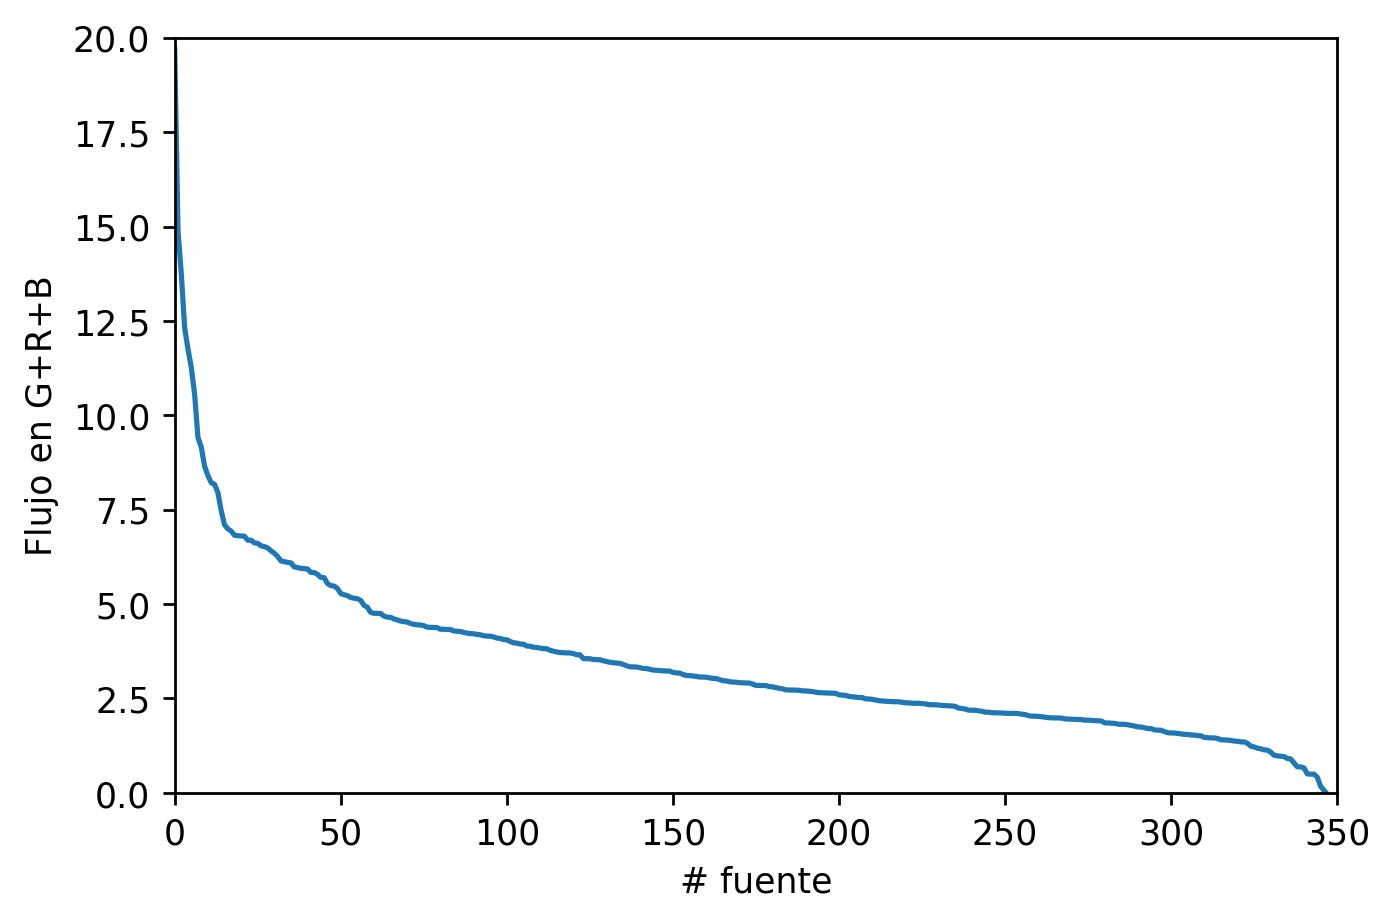

In [3]:
GRB=Corr_iss062e102209G2F.loc[:,'aperture_sum']+Corr_iss062e102209R1F.loc[:,'aperture_sum']+Corr_iss062e102209B4F.loc[:,'aperture_sum']

GRB_stat=GRB.sort_values(ascending=False,ignore_index=True)
plt.plot(GRB_stat,'-')
plt.xlim(0, 350)
plt.ylim(0, 20)
plt.ylabel('Flujo en G+R+B') #titulo del eje y
plt.xlabel('# fuente')



Text(3.9932232934810368, 61.425000000000004, 'Median: 2.88')

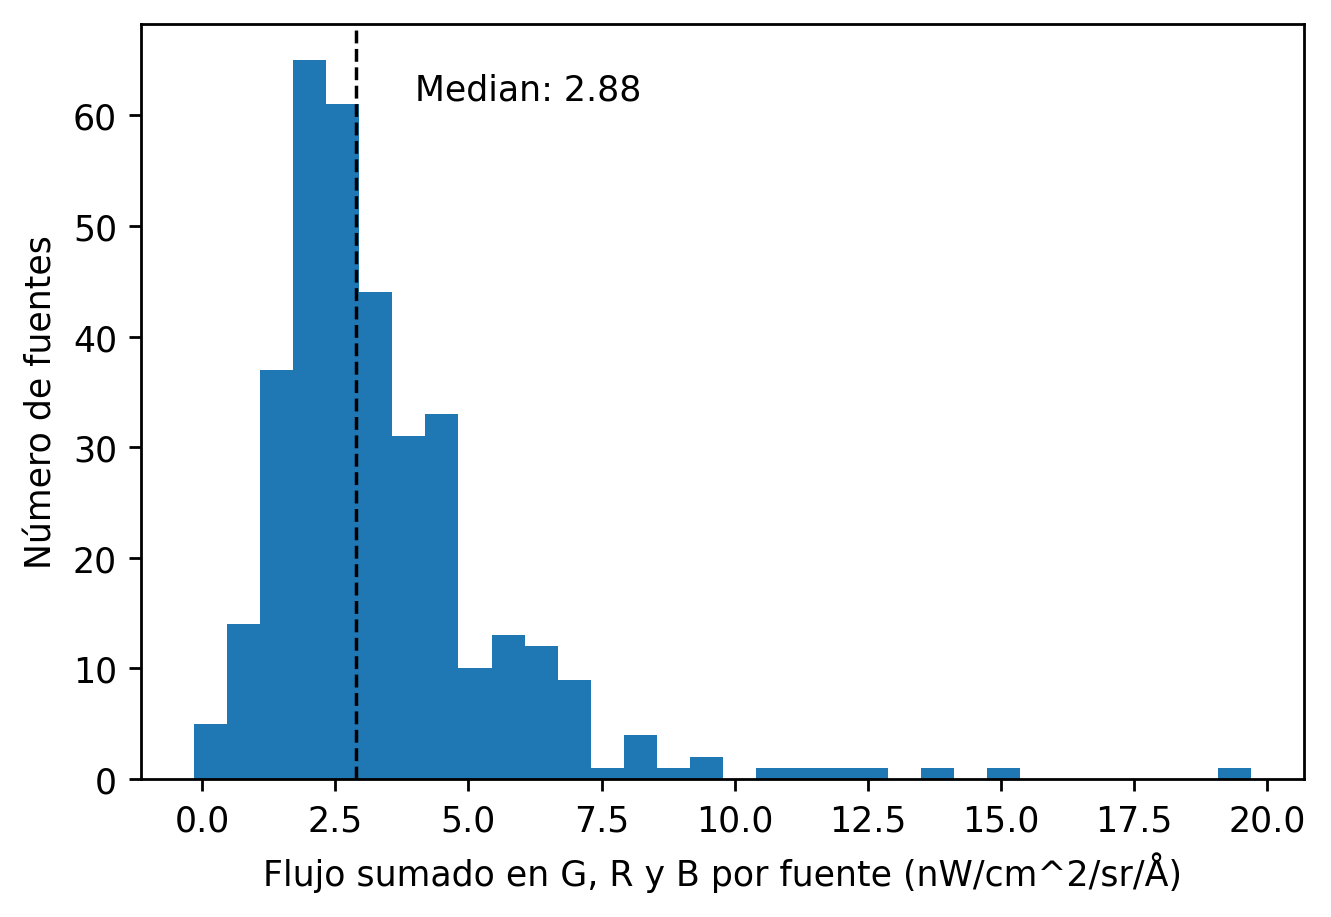

In [4]:
np.histogram(GRB_stat)
plt.hist(GRB_stat, bins='auto')
plt.ylabel('Número de fuentes') #titulo del eje y
plt.xlabel('Flujo sumado en G, R y B por fuente (nW/cm^2/sr/Å)')
# plt.axvline(GRB_stat.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(GRB_stat.median(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
# plt.text(x.mean()*8, max_ylim*0.9, 'Mean: {:.2f}'.format(GRB_stat.mean()))
plt.text(x.median()*8, max_ylim*0.9, 'Median: {:.2f}'.format(GRB_stat.median()))

Nº puntos totales=100
% CajaLPS0.0
% Caja HPS=0.0
% Caja HPS_LEDPCamber_wl_incand_otherLEDS=0.0
% cajaNeutralWhiteLamps_LED3000K_fluorescents=0.0
% cajaHighHg_GreenishLEDs=0.0
% CajaLEDs4000or5000K_veryblue_MHlamps=100.0
% CajaEWL_ECL_orProblemswithND=0.0
% Puntos fuera de la zona=0.0


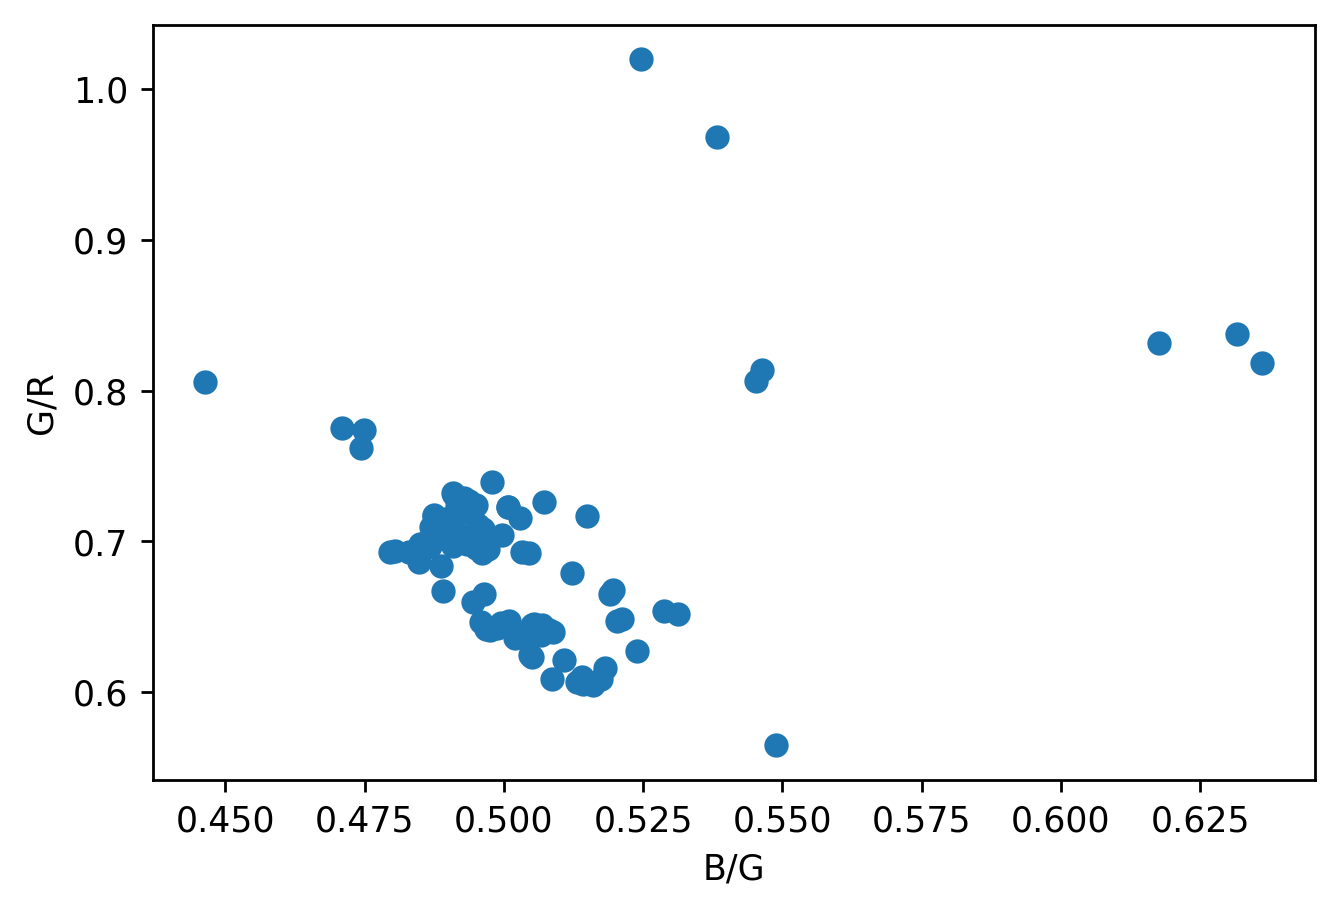

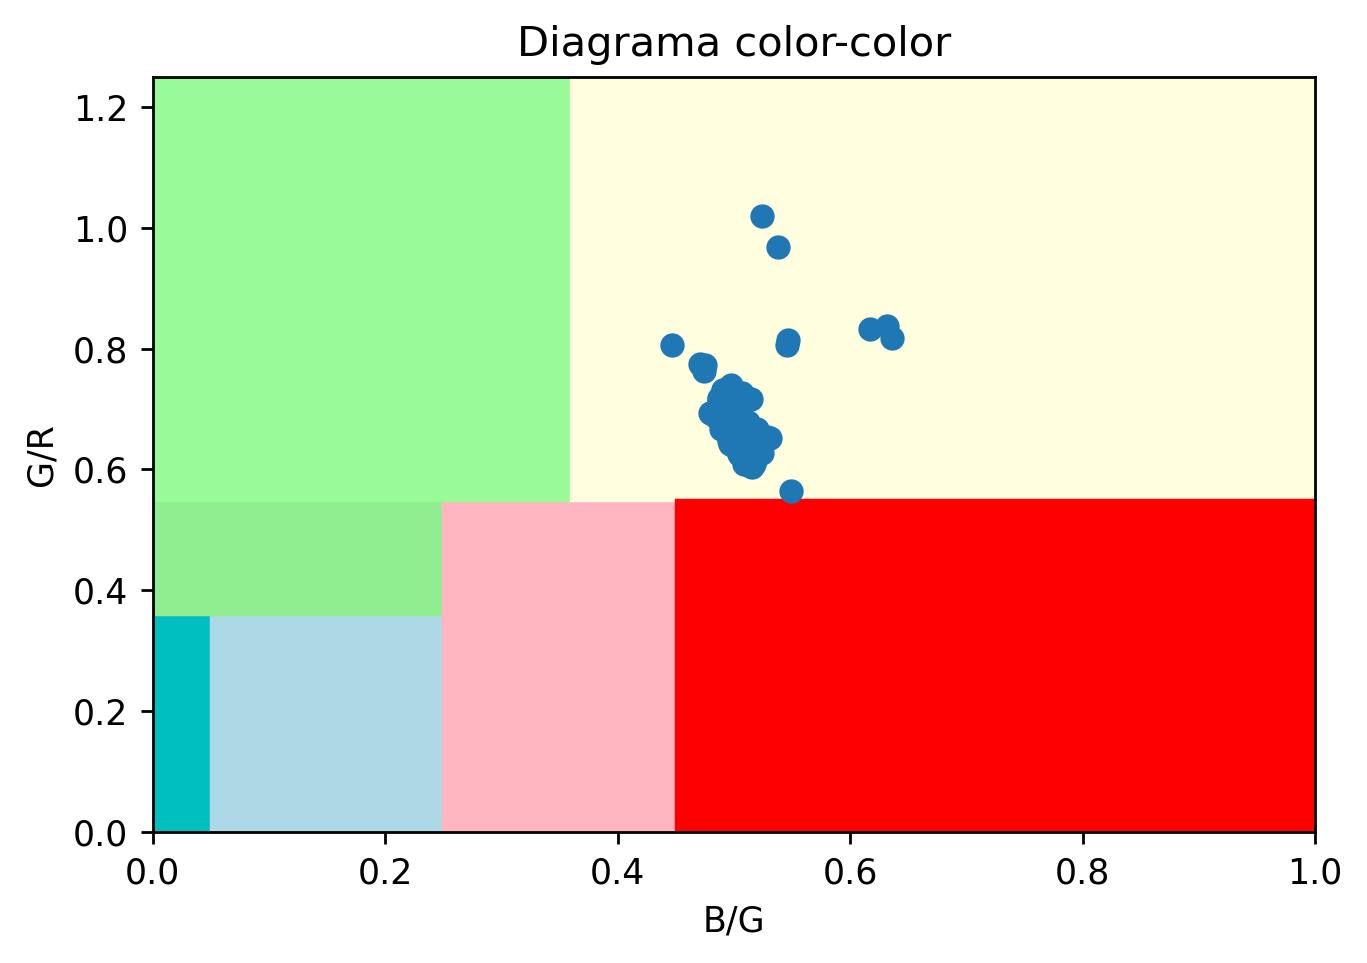

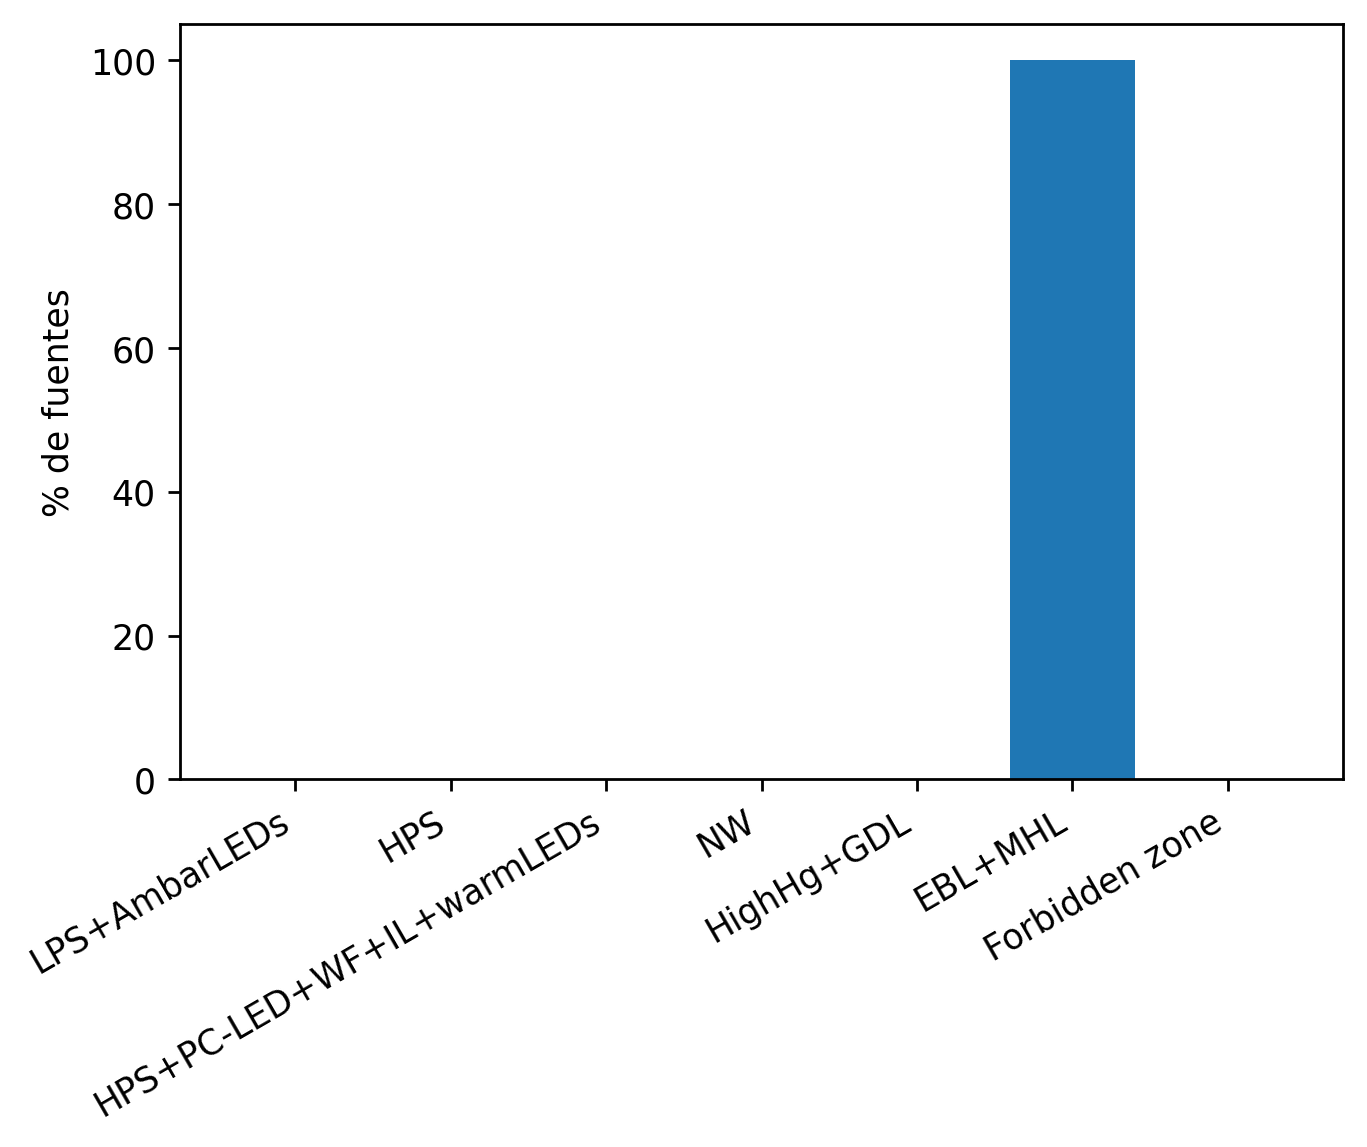

In [5]:
#ANÁLISIS DEL COLOR DE UNA SOLA IMAGEN EN SUS 4 BANDAS Y LAS PRIMERAS 100 FUENTES EN FLUJO

directory_load = '.\Ficheros_fits_test\\'
files = [i for i in os.listdir(directory_load) if i.startswith("Corr_iss062e102209")]
tablas=[]
canales=[]

for index, file in enumerate(files):
    if str(file).endswith('.cal2N.Ao2_rect.fits'):
        canal = str(file)[:-(len('.cal2N.Ao2_rect.fits'))]
        canales.append(canal)
    img = fits.open(directory_load+file)
    tabla = pd.read_csv('.\Fuentes_puntuales_referencia_verde\\'+str(file)+'.csv',sep=';')
    sources_byflux=tabla.sort_values(by='aperture_sum', ascending=False, ignore_index=True)
    sources_byflux100=sources_byflux.loc[0:99]
    tablas.append(sources_byflux100)
    
Corr_iss062e102209B4F=tablas[0]
Corr_iss062e102209G2F=tablas[1]
Corr_iss062e102209G3F=tablas[2]
Corr_iss062e102209R1F=tablas[3]



G_R=Corr_iss062e102209G2F.loc[:,'aperture_sum']/Corr_iss062e102209R1F.loc[:,'aperture_sum']
B_G=Corr_iss062e102209B4F.loc[:,'aperture_sum']/Corr_iss062e102209G2F.loc[:,'aperture_sum']

plt.plot(B_G,G_R,'o')
plt.ylabel('G/R')
plt.xlabel('B/G')

#CONTADOR. Cuenta los puntos en cada región


x=B_G
y=G_R
N_tot=len(G_R) #número total de puntos.
print("Nº puntos totales="+str(N_tot))

#se dibuja el diagrama de color-color
plt.figure()
plt.plot(x,y,'o')
plt.title('Diagrama color-color') 
plt.ylabel('G/R') #titulo del eje y
plt.xlabel('B/G') #titulo del eje x

#caja 1:

points = np.column_stack([x, y])
cajaLPS = np.array([[0,0.05,0.05,0,0], [0,0,0.36,0.36,0]]).T #definición de la caja por puntos low pressure sodium/ pure amber led
path = mpath.Path(cajaLPS)
points_inside = points[path.contains_points(points)]
plt.fill([0,0.05,0.05,0,0], [0,0,0.36,0.36,0], color='c', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape #contador de puntos dentro de la región
a_por100=100*a/N_tot #cálculo del porcentaje de puntos respecto al numero total de estrellas
LPS=a_por100
print("% CajaLPS" +str(LPS))

#caja 2

points = np.column_stack([x, y])
cajaHPS = np.array([[0.05,0.25,0.25,0.05,0.05], [0,0,0.36,0.36,0]]).T #definición de la caja por puntos high pressure sodium
path = mpath.Path(cajaHPS)
points_inside = points[path.contains_points(points)]
plt.fill([0.05,0.25,0.25,0.05,0.05], [0,0,0.36,0.36,0], color='lightblue', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
HPS=a_por100
print("% Caja HPS=" +str(HPS))

#caja 3

points = np.column_stack([x, y])
cajaHPS_LEDPCamber_wl_incand_otherLEDS=np.array([[0,0.25,0.25,0,0], [0.36,0.36,0.55,0.55,0.36]]).T   #combination of HPS, LED phosphor converted (PC) amber, some warm light fluorescents, incandescent lamps and other warm LEDs
path = mpath.Path(cajaHPS_LEDPCamber_wl_incand_otherLEDS)
points_inside = points[path.contains_points(points)]
plt.fill([0,0.25,0.25,0,0], [0.36,0.36,0.55,0.55,0.36], color='lightgreen', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
HPS_LEDPCamber_wl_incand_otherLEDS=a_por100
print("% Caja HPS_LEDPCamber_wl_incand_otherLEDS=" +str(HPS_LEDPCamber_wl_incand_otherLEDS))

#caja 4

points = np.column_stack([x, y])
cajaNeutralWhiteLamps_LED3000K_fluorescents=np.array([[0.25,0.45,0.45,0.25,0.25], [0,0,0.55,0.55,0]]).T  #where neutral white lamps like LED 3000k and many fluorescents lie
path = mpath.Path(cajaNeutralWhiteLamps_LED3000K_fluorescents)
points_inside = points[path.contains_points(points)]
plt.fill([0.25,0.45,0.45,0.25,0.25], [0,0,0.55,0.55,0], color='lightpink', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
NeutralWhiteLamps_LED3000K_fluorescents=a_por100
print("% cajaNeutralWhiteLamps_LED3000K_fluorescents=" +str(NeutralWhiteLamps_LED3000K_fluorescents))

#caja 5

points = np.column_stack([x, y])
cajaHighHg_GreenishLEDs=np.array([[0,0.36,0.36,0,0], [0.55,0.55,1.25,1.25,0.55]]).T    #we find lamps with high mercury content, and some LEDs many of which have a greenish colour as a result of degradation from their original specification
path = mpath.Path(cajaHighHg_GreenishLEDs)
points_inside = points[path.contains_points(points)]
plt.fill([0,0.36,0.36,0,0], [0.55,0.55,1.25,1.25,0.55], color='palegreen', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
HighHg_GreenishLEDs=a_por100
print("% cajaHighHg_GreenishLEDs=" +str(HighHg_GreenishLEDs))


#caja 6:

points = np.column_stack([x, y])
cajaLEDs4000or5000K_veryblue_MHlamps=np.array([[0.36,1,1,0.36,0.36], [0.55,0.55,1.25,1.25,0.55]]).T   #has the more bluish lamps like LEDs of 4000k and 5000k, and metal halide lamps
path = mpath.Path(cajaLEDs4000or5000K_veryblue_MHlamps)
points_inside = points[path.contains_points(points)]
plt.fill([0.36,1,1,0.36,0.36], [0.55,0.55,1.25,1.25,0.55], color='lightyellow', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
LEDs4000or5000K_veryblue_MHlamps=a_por100
print("% CajaLEDs4000or5000K_veryblue_MHlamps=" +str(LEDs4000or5000K_veryblue_MHlamps))


#caja 7:

points = np.column_stack([x, y])
cajaEWL_ECL_orProblemswithND= np.array([[0.45,1,1,0.45,0.45], [0,0,0.55,0.55,0]]).T
path = mpath.Path(cajaEWL_ECL_orProblemswithND)
points_inside = points[path.contains_points(points)]
plt.fill([0.45,1,1,0.45,0.45], [0,0,0.55,0.55,0], color='red', linewidth=1, linestyle='-')
points_inside.dtype
a,b=points_inside.shape
a_por100=100*a/N_tot
EWL_ECL_orProblemswithND=a_por100
print("% CajaEWL_ECL_orProblemswithND=" +str(EWL_ECL_orProblemswithND))

print("% Puntos fuera de la zona=" +str(100-(LPS+HPS+HPS_LEDPCamber_wl_incand_otherLEDS+NeutralWhiteLamps_LED3000K_fluorescents+HighHg_GreenishLEDs+LEDs4000or5000K_veryblue_MHlamps+EWL_ECL_orProblemswithND)))


plt.xlim(0, 1)
plt.ylim(0, 1.25)
plt.show()

names = ['LPS+AmbarLEDs', 'HPS', 'HPS+PC-LED+WF+IL+warmLEDs','NW','HighHg+GDL','EBL+MHL','Forbidden zone']
values = [LPS, HPS, HPS_LEDPCamber_wl_incand_otherLEDS,NeutralWhiteLamps_LED3000K_fluorescents,HighHg_GreenishLEDs,LEDs4000or5000K_veryblue_MHlamps,EWL_ECL_orProblemswithND]

plt.figure()

plt.plot()
plt.bar(names, values)
plt.xticks(rotation=30, ha='right')
plt.ylabel('% de fuentes') #titulo del eje y
plt.show()

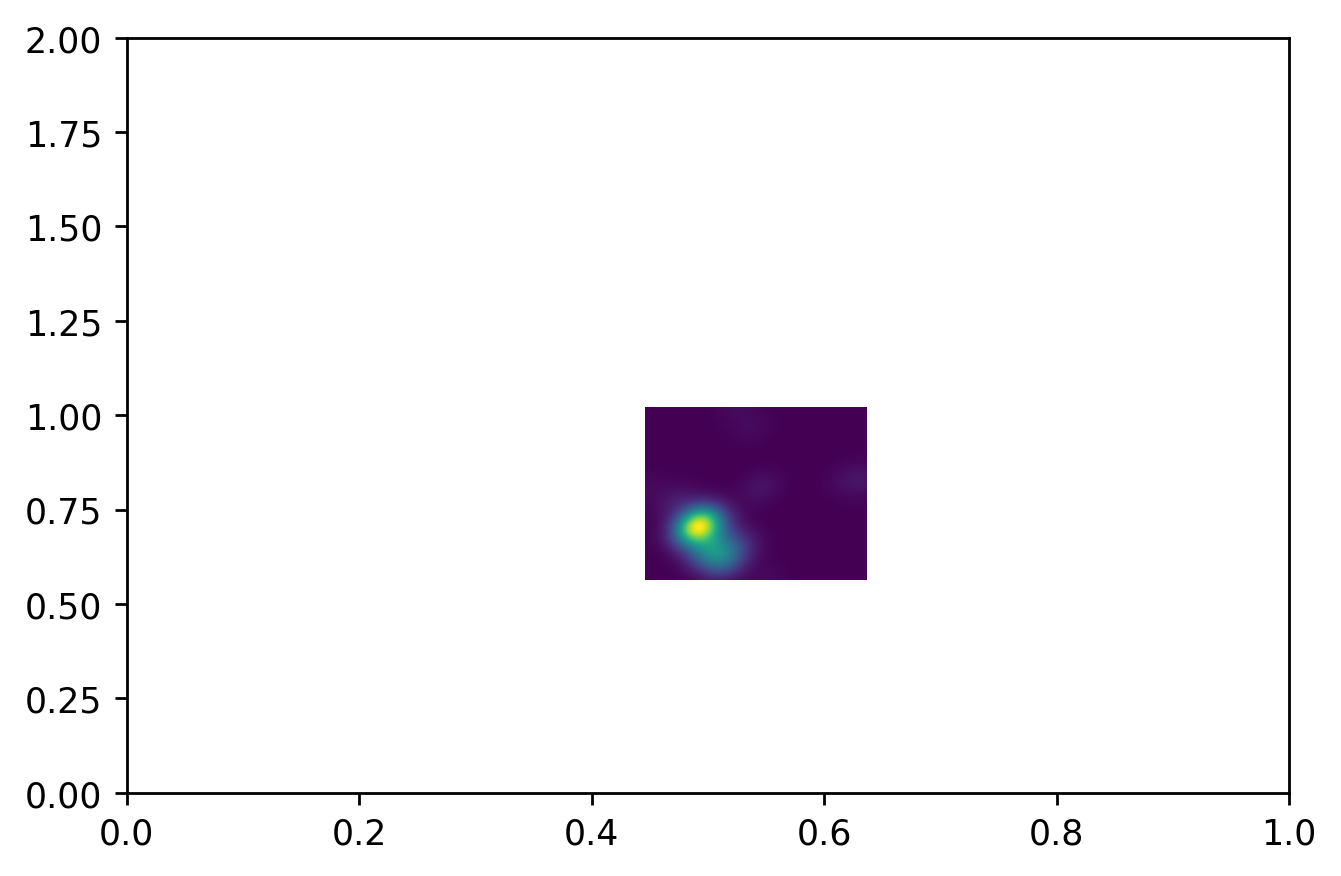

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=500
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape),shading='auto')
plt.xlim(0, 1)
plt.ylim(0, 2)
plt.show()

In [7]:
#ESTE CÓDIGO ES IMPORTANTE LA PRIMERA VEZ QUE SE CORRE EL ARCHIVO. Luego es mejor no ejecutarlo o podría crear problemas al sobreescribir archivos
# #añade las coincidencias a los archivos de la referencia verde
# contador=0

# # file='Corr_iss062e102209G2F.cal2N.Ao2_rect.fits.csv'
# referencia_identificados=pd.read_table('.\Identificacion\\Corr_iss062e102209G2F.cal2N.Ao2_rect.fits.csv', sep=";")

# files= [j for j in os.listdir('.\Fuentes_puntuales_referencia_verde\\')]

# for index, file in enumerate(files):
#     if file.startswith("Corr_iss062e102209"):
#         canal_identificado=pd.read_table('.\Fuentes_puntuales_referencia_verde\\'+str(file), sep=";")
#         canal_identificado['lugar']=referencia_identificados['lugar']
#         canal_identificado.to_csv('.\Fuentes_puntuales_referencia_verde_identificados\\'+str(file),sep=";",index=False)
#         print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>Creado el fichero '+'referencia'+str(file))
#         contador=contador+1
#         completado=round(((contador/(4))*100), 2)
#         print('\r', str(completado)+'% Completado', sep='', end='', flush=True)  

Text(0.5, 0, 'Flujo (nW/cm^2/sr/Å)')

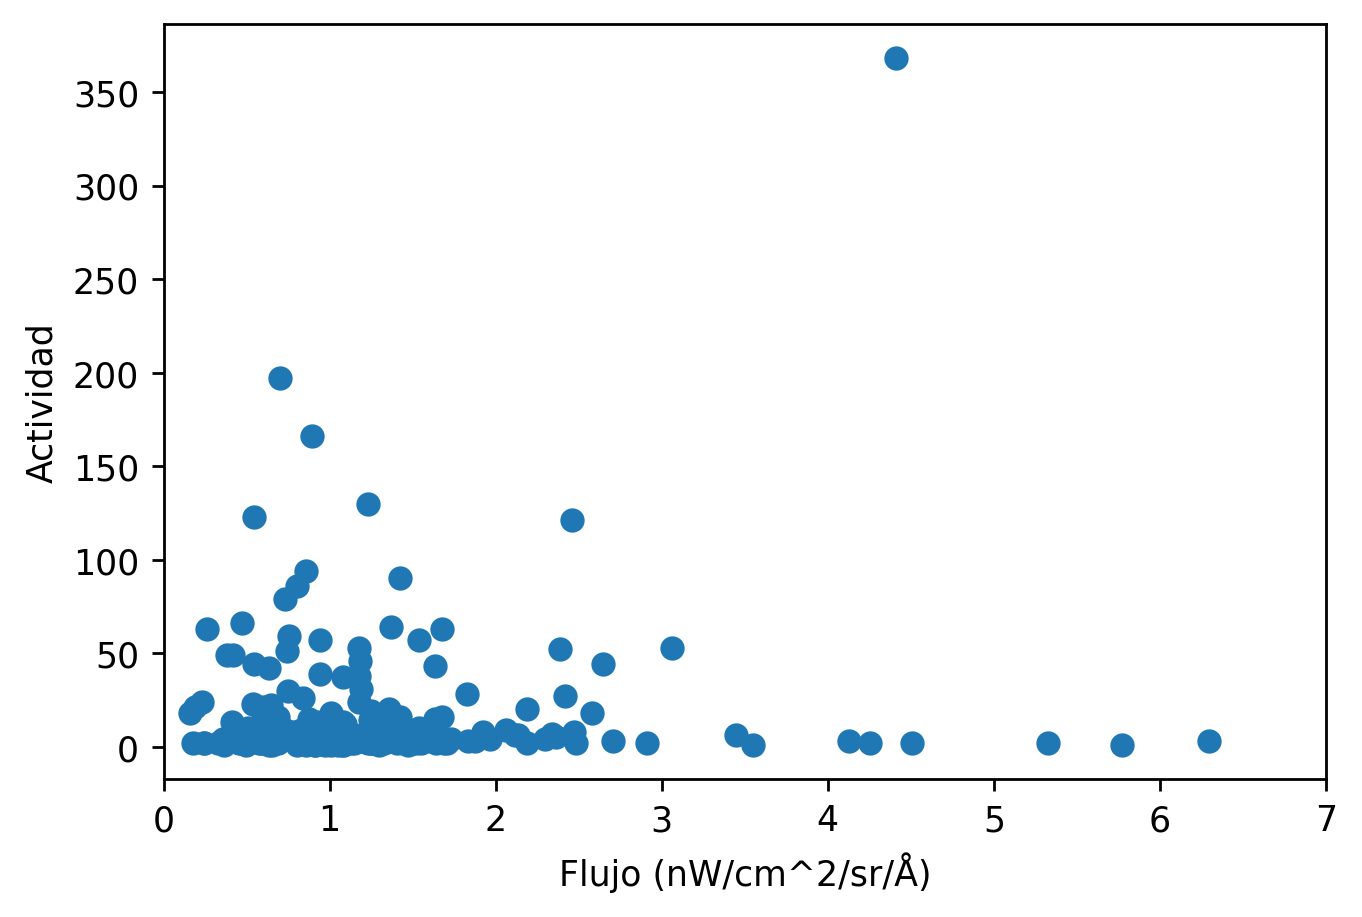

In [8]:
file='Corr_iss062e102209G2F.cal2N.Ao2_rect.fits.csv'
tabla=pd.read_table('.\Fuentes_puntuales_referencia_verde_identificados\\'+str(file), sep=";") #tabla de identificados
tabla_flux=tabla.sort_values('aperture_sum',ascending=False,ignore_index=True) #ordenar por flujo
tabla_flux.loc[:,'lugar'] #columna de lugares

v=np.linspace(0,len(tabla_flux)-1,len(tabla_flux))
actividad=[]
flujo=[]

for indice in v:
    try:
        lugares=tabla_flux.loc[indice,'lugar'] #elemento n de la lista de lugares aun sin separar
        listita=lugares.split(sep=',') #vector cuyos elementos son los lugares individuales. Lugares separados.
        listita.pop(0) #quitar el elemento 0 que es un espacio
        actividad_i=len(listita) #cálculo de la actividad de este elemento
        actividad.append(actividad_i)
        flujo_i=tabla_flux.loc[indice,'aperture_sum']
        flujo.append(flujo_i)
        
    except AttributeError:
        actividad_i=0
        actividad.append(actividad_i)
        flujo_i=tabla_flux.loc[indice,'aperture_sum']
        flujo.append(flujo_i)

        
d = {'flujo': flujo, 'actividad': actividad}
df = pd.DataFrame(data=d)
df =df[df['actividad'] !=0]
flujo=df['flujo']
actividad=df['actividad']

plt.plot(flujo,actividad, 'o')
plt.xlim(0, 7)
plt.ylabel('Actividad') #titulo del eje y
plt.xlabel('Flujo (nW/cm^2/sr/Å)') #titulo del eje y

Text(0, 0.5, 'Número de puntos de interés')

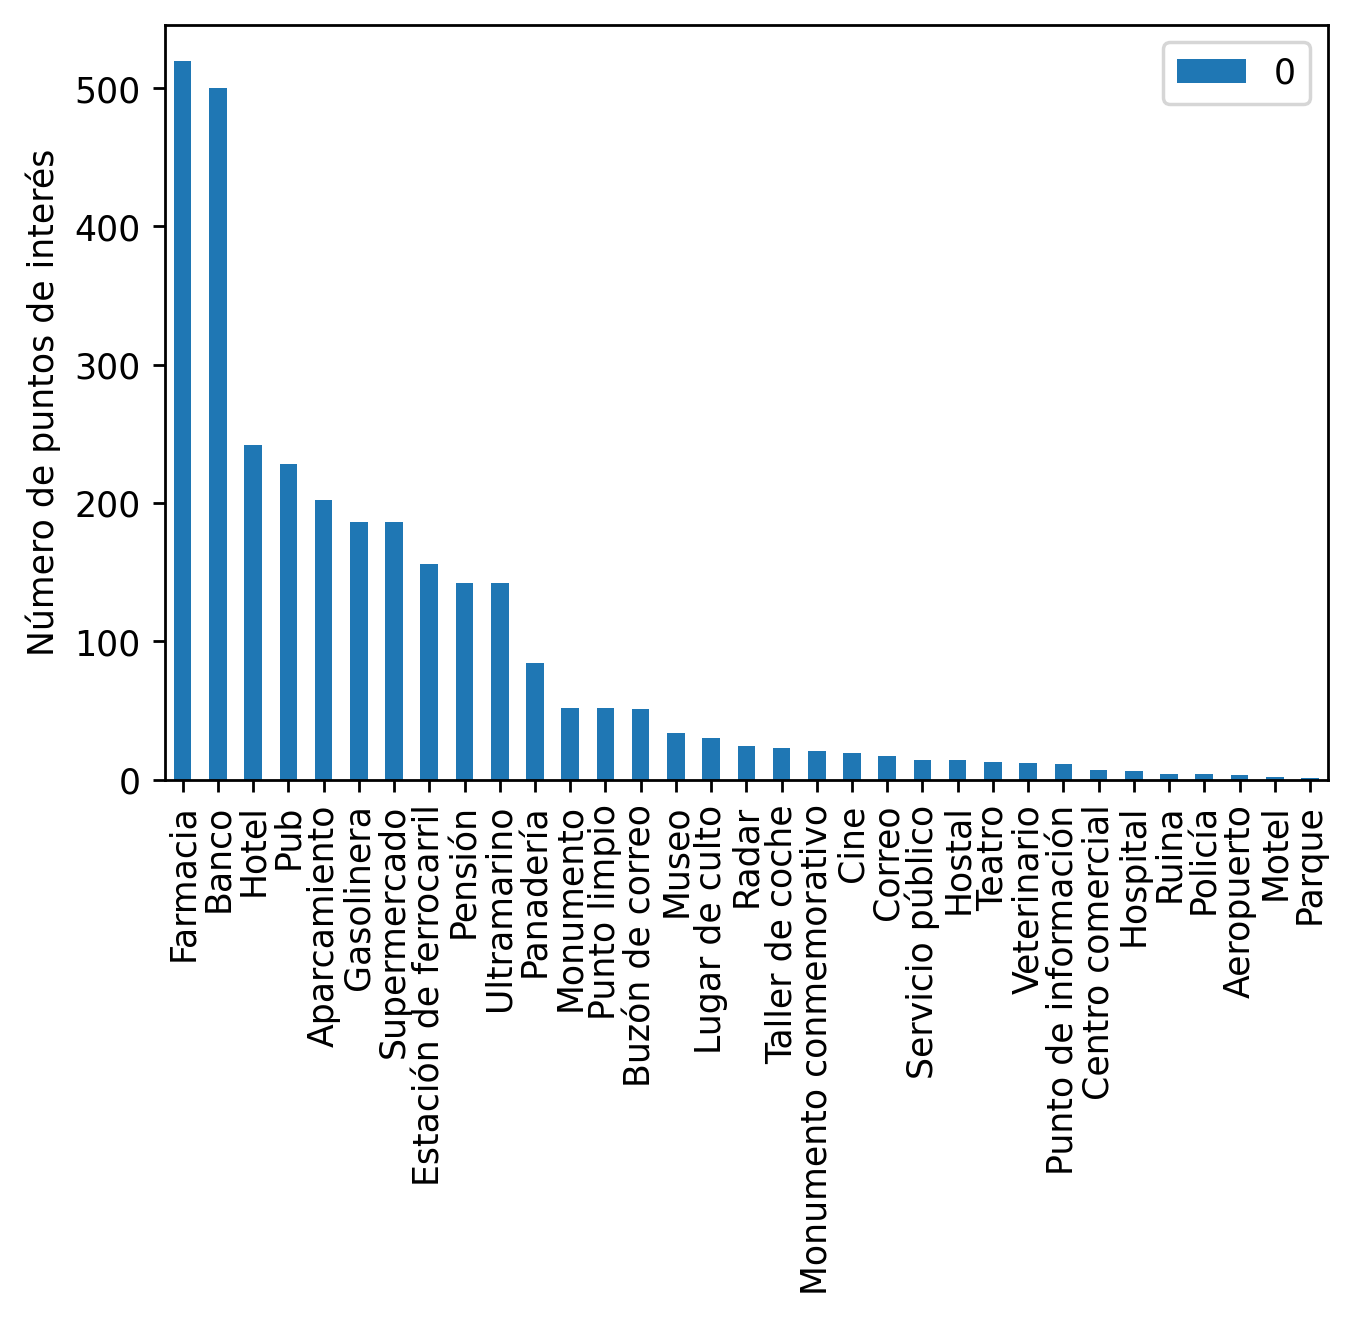

In [9]:
#HISTOGRAMA DE LUGARES

file='Corr_iss062e102209G2F.cal2N.Ao2_rect.fits.csv'
tabla=pd.read_table('.\Fuentes_puntuales_referencia_verde_identificados\\'+str(file), sep=";") #tabla de identificados
tabla_flux=tabla.sort_values('aperture_sum',ascending=False,ignore_index=True) #ordenar por flujo
tabla_flux.loc[:,'lugar'] #columna de lugares

v=np.linspace(0,len(tabla_flux)-1,len(tabla_flux))
lista_v0=[]

for indice in v:
    try:
        lugares=tabla_flux.loc[indice,'lugar'] #elemento n de la lista de lugares aun sin separar
        listita=lugares.split(sep=',') #vector cuyos elementos son los lugares individuales. Lugares separados.
        listita.pop(0) #quitar el elemento 0 que es un espacio
        lista_v0.append(listita) #cálculo de la actividad de este elemento
    except AttributeError:
        pass
    
files= [j for j in os.listdir('.\Bases_de_datos\\')]
categorias=[]
for file in files:
    file=file[:-4]
    fi=str(file).replace('_', ' ')
    categorias.append(fi)
    
lista=[]

for indice in np.linspace(0,len(lista_v0)-1,len(lista_v0)):
    l=len(lista_v0[int(indice)])
    
    for indice2 in np.linspace(0,l-1,l):
        elementos=lista_v0[int(indice)][int(indice2)]
        
        for indice3 in np.linspace(0,len(categorias)-1,len(categorias)):
            if elementos.startswith(categorias[int(indice3)]):
                lista.append(categorias[int(indice3)])
import pandas
from collections import Counter
letter_counts = Counter(lista)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df_order=df.sort_values(0, ascending=False)
df_order.plot(kind='bar')
plt.ylabel('Número de puntos de interés') #titulo del eje y